![Авто](https://img2.goodfon.ru/wallpaper/nbig/4/4a/auto-cars-ac-cobra-cobra.jpg)

## Библиотеки

In [ ]:
!pip install -q tensorflow==2.8.0

     |████████████████████████████████| 462 kB 4.1 MB/s 


In [ ]:
!pip install albumentations -q -U

     |████████████████████████████████| 102 kB 11.7 MB/s 
     |████████████████████████████████| 47.8 MB 2.1 MB/s 


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-hiuo7hd_
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-hiuo7hd_


In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor update tensorflow

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-t3drrhui
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-t3drrhui
     |████████████████████████████████| 60.5 MB 1.3 MB/s 
     |████████████████████████████████| 462 kB 50.7 MB/s 
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29638 sha256=eecd3f8f5ff33307a5c18bfcfda7192186cabe6869307019492ee9b2b3f12a8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-a37_09sg/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras import initializers

import albumentations as albumentations
from ImageDataAugmentor.image_data_augmentor import *

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

import sys, os, time, zipfile

import cv2
from PIL import Image

print('Python        :', sys.version.split('\n')[0])
print('Numpy         :', np.__version__)
print('Tensorflow    :', tf.__version__)
print('Keras         :', tf.keras.__version__)
print('Albumenations :', albumentations.__version__)

Python        : 3.7.12 (default, Jan 15 2022, 18:48:18) 
Numpy         : 1.21.5
Tensorflow    : 2.8.0
Keras         : 2.8.0
Albumenations : 1.1.0


## Подготовка данных

Для целей повышения точности модели в интернете был собран дополнительный сет данных с двух сайтов: [авто.ру](https://auto.ru/) и [дром.ру](https://www.drom.ru/).

Общий дата сет для тернировки модели теперь составляет 24 059 образцов. Дополнительные образцы собирались сбалансированно по нужным классам моделей.

Код сбора данных находится в файле Parsing_train.ipynb. Применялись библиотеки request для запросов к сайтам и beutifulsoup для вылавливания фото автомобилей по тегам.

Дополнительные фото автомобилей имеют меньшие разрешения.

Данные лежат в архиве на google диске. Тренировка модели проводилась на полном (с допданными) сете.

In [ ]:
#установим связь с гугл диском, на котром лежат данные
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#посмотрим наши файлы, лежащие в папке modul_8/Data
!ls /content/gdrive/MyDrive/module_8/Data

#данные архивированы, так как чтение неархивированных данных в моделировании занимает огромное время
#в файле cars.zip лежит объединенный датасет (train сет + доп фотографии с сайтов авто.ру и дром.ру)

cars.zip  sample-submission.csv  test_upload  train.zip


In [ ]:
!nvidia-smi

Wed Mar 16 11:14:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#сделаем список имен классов автомобилей
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

In [ ]:
#зададим пути к данным на гугл диске

sample_submission_path = '/content/gdrive/MyDrive/module_8/Data/sample-submission.csv'
zip_file_cars = '/content/gdrive/MyDrive/module_8/Data/cars.zip'
zip_file_train = '/content/gdrive/MyDrive/module_8/Data/train.zip'

In [ ]:
#загрузим данные из архивов для использования их в моделировании
cars = zipfile.ZipFile(zip_file_cars, 'r')
cars.extractall()

train = zipfile.ZipFile(zip_file_train, 'r')
train.extractall()

print(os.listdir())

#в 'train_additional' лежит наш полный датасет для моделирования

['.config', 'train_additional', 'gdrive', 'train', 'test_upload', 'sample_data']


In [ ]:
#зададим пути к данным

train_add_path = 'train_additional' #основной (дополненный) сет данных для моделирования
train_path = 'train' #исходный сет данных с Kaggle
sub_path = 'test_upload'#тестовый сет данных для представления результата на Kaggle

In [ ]:
# Основные настройки.

batch_size           = 16 # варьируется в разных вариантах моделирования от 10 до 32
val_split            = 0.15 # сколько данных выделяем на тест
seed                 = 0

CLASS_NUM            = 10  # количество классов в нашей задаче
image_size           = (150, 150) # варьируется размер в разных вариантах моделирования от 90х90 до 520х520
image_channels         = 3   # у RGB 3 канала
input_shape          = (*image_size, image_channels)

#график скорости обучения, initial_learning_rate в размере 1е-4 показала себя наилучшим образом
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps = 10000,
    decay_rate=0.94)

#lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
#    initial_learning_rate=0.045,
#    decay_steps=1000,
#    decay_rate=0.94)

Генераторы трейн, валидационного и submission сетов от Keras не использовались в финальных моделях. Практически все моделирование осуществлялось с пакетом аугментации данных Albumenation. Аугментация от Keras использовалась только в собственной нейронной сети для первоначальной инициализации весов на сетах малого размера (10-15% от полного сета), так как с аугментацией от Albumenation собственная нейросеть иногда застревала в седловых точках (переставала учиться).

In [ ]:
#Создададим генераторы сетов
train_add_datagen = ImageDataGenerator(
    rescale=1/255,
    #samplewise_center=True,
    #samplewise_std_normalization=True,
    validation_split=val_split,
    
    #Параметры аугментаций:
    horizontal_flip=True,
    rotation_range=10,
    #shear_range=0.1,
    #brightness_range=(0.6, 1.4),
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #zoom_range=[0.9,1.3],
    fill_mode='constant', #('nearest' is default, 'reflect', 'wrap'),
)

val_add_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=val_split,
)

sub_datagen = ImageDataGenerator(
    rescale=1/255
)
#сгенерируем тренировочные данные
train_add_generator = train_add_datagen.flow_from_directory(
    train_add_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed,
    subset='training'
)
#сгенерируем оценочные данные
val_add_generator = val_add_datagen.flow_from_directory(
    train_add_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed,
    subset='validation'
)
#сгенерируем оценочные данные для прогнозирования сабмита на Kaggle
sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 2412 images belonging to 10 classes.
Found 21647 images belonging to 10 classes.
Found 6675 validated image filenames.


## Albumenation

Пакет Albumenation был основным пакетом для генерации аугментированных датасетов для моделирования, так как давал заметно лучшуюю точность на валидационном сете в сравнении с аугментацией Keras.

In [ ]:
augumentation = albumentations.Compose([
    albumentations.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=10, 
                       p=.75), 
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4,
                          value=None,
                          mask_value=None,
                          always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=210, width=240),
        albumentations.CenterCrop(height=230, width=200),
                                  ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.15),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(image_size[0],image_size[1])
])

In [ ]:
train_add_datagen = ImageDataAugmentor(
    rescale=1/255, 
    augment = augumentation,
    validation_split=val_split,
)

val_add_datagen = ImageDataAugmentor(
    rescale=1/255,
    validation_split=val_split,
)

sub_datagen = ImageDataAugmentor(
     rescale=1/255
)

train_add_generator = train_add_datagen.flow_from_directory(
    train_add_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='training'
)

val_add_generator = val_add_datagen.flow_from_directory(
    train_add_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=0,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:333: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 20455 images belonging to 10 classes.
Found 3604 images belonging to 10 classes.
Found 6675 validated image filenames.


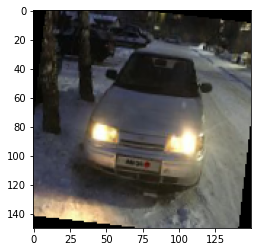

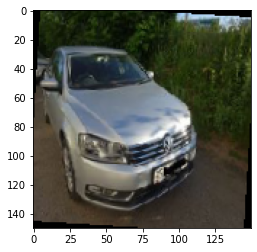

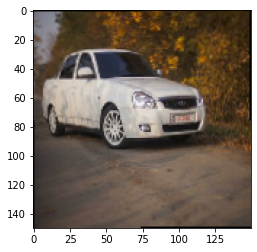

In [ ]:
#чек фотографий
#надо сказать, что попадались иногда некачественные фото (например, салон авто)
#чистил датасет, скачанный из инета, но видимо небольшая часть плохих фото все-таки осталась
x,y = train_add_generator.next()
for i in range(3):
    image = x[i]
    #img = image.astype(np.uint8)
    plt.imshow(image)
    plt.show()
    #print(image)

## Создадим собственную сверточную нейронную сеть

Для более глубокого понимания архитектур современных сверточных сетей в этом разделе в функциональном стиле написана нейросеть, основанная на архитектуре Xception. Эту собственную сеть можно было менять и ставить разные эксперименты, что давало лучшее представление о работе сети. Сеть включает 4 блока:


*  входной блок, включающий два обычных сверточных слоя и цикл из трех шагов, в каждом из которых есть два слоя раздельной свертки SeparableConv2D, что значительно снижает стоимость вычислений в отличие от обычных сверточных слоев.
*   средний блок - это просто циклы (количество которых можно менять) из  трех последовательных слоев SeparableConv2D с количеством сверточных фильтров 728
*  выходной блок - четыре слоя SeparableConv2D
*  нашлепка в виде полносвязного слоя.

Необходимо сказать, что во всех блоках (кроме нашлепки) используются так называемые shorcuts (короткие пути для укорачивания длины самых коротких путей в графе обратного распространения градиентов, так, чтобы градиенты не становились исчезающе малыми).

Помимо shortcuts вставлись дополнительные блок SE-Resnet (squize excitement). Смысл их в том, чтобы придать разный вес разным каналам, выходящим из сверточных слоев. Эти блоки больше характерны для EfficientNet арххитектуры.

Далее представлены пперечисленные блоки в виде функций:

In [ ]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Multiply, GlobalMaxPooling2D, Reshape
from tensorflow.keras.layers import Activation, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, Add

In [ ]:
from tensorflow.python.keras.layers.merge import Multiply
#initializer = tf.keras.initializers.RandomNormal(mean=0.01, stddev=0.2, seed=None)
initializer = tf.keras.initializers.HeUniform(seed=None)
initializer_1 = tf.keras.initializers.GlorotUniform(seed=None)

L2=1e-8
f_activation = 'relu'

In [ ]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Activation(f_activation)(x)
    

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Activation(f_activation)(x)

    previous_block_activation = x

    for size in [128,256,728] :

        x = Activation(f_activation)(x)
        x = SeparableConv2D(size, 3, padding='same', depthwise_regularizer=regularizers.l2(l2=L2))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)

        x = Activation(f_activation)(x)
        x = SeparableConv2D(size, 3, padding='same',  depthwise_regularizer=regularizers.l2(l2=L2))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        
        #SE-ResNet block
        #y = GlobalAveragePooling2D()(x)
        #y = Reshape((1, 1, size))(y)
        #y = Dense(size//16, activation=f_activation)(y)
        #y = BatchNormalization()(y)
        #y = Dropout(0.25)(y)
        #y = Dense(size)(y)
        #y = Activation(activation='sigmoid')(y)
        #x = Multiply()([x, y])
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        x = BatchNormalization()(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = Add()([x, residual])
        previous_block_activation = x

    return x

In [ ]:
def middle_flow(x, num_blocks=8):

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation(f_activation)(x)
        x = SeparableConv2D(728, 3, padding='same', depthwise_regularizer=regularizers.l2(l2=L2))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        
        x = Activation(f_activation)(x)
        x = SeparableConv2D(728, 3, padding='same', depthwise_regularizer=regularizers.l2(l2=L2))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        
        x = Activation(f_activation)(x)
        x = SeparableConv2D(728, 3, padding='same', depthwise_regularizer=regularizers.l2(l2=L2))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)
        
        x = Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [ ]:
def exit_flow(x) :

    previous_block_activation = x

    x = Activation(f_activation)(x)
    x = SeparableConv2D(728, 3, padding='same', depthwise_regularizer=regularizers.l2(l2=L2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)
    
    x = Activation(f_activation)(x)
    x = SeparableConv2D(1024, 3, padding='same', depthwise_regularizer=regularizers.l2(l2=L2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = BatchNormalization()(x)
    
    x = Add()([x, residual])

    x = Activation(f_activation)(x)
    x = SeparableConv2D(728, 3, padding='same', depthwise_regularizer=regularizers.l2(l2=L2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)

    x = Activation(f_activation)(x)
    x = SeparableConv2D(1024, 3, padding='same', depthwise_regularizer=regularizers.l2(l2=L2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.15)(x)

    #SE-ResNet block
    #y = GlobalAveragePooling2D()(x)
    #y = Reshape((1, 1, 1024))(y)
    #y = Dense(1024//16, activation=f_activation)(y)
    #y = BatchNormalization()(y)
    #y = Dropout(0.25)(y)
    #y = Dense(1024)(y)
    #y = Activation(activation='sigmoid')(y)
    #x = Multiply()([x, y])

    #residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    #x = Add()([x, residual])

    x = GlobalAveragePooling2D()(x)

    return x

In [ ]:
def dense_flow(x):
  x = Dense(128)(x)
  x = Activation(f_activation)(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)
  #x = Activation(f_activation)(x)
  #x = Dense(512, kernel_initializer=initializer_1)(x)
  #x = BatchNormalization()(x)
  #x = Dropout(0.5)(x)
  x = Dense(CLASS_NUM)(x)
  
  return x

In [ ]:
#скалдываем все 4 блока в модель
imgs = Input(shape=input_shape)
output = dense_flow(exit_flow(middle_flow(entry_flow(imgs))))
model_sota = keras.Model(inputs=imgs, outputs=output)

In [ ]:
#проверям, что на выходе получился тензор нужного нам размера
output.shape

TensorShape([None, 10])

In [ ]:
K.clear_session()
#посмотрим на характеристики слоев модели, а также на ее архитектуру
model_sota.summary()
#keras.utils.plot_model(model_sota, show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
#model_sota.trainable= True

In [ ]:
len(model_sota.layers)

175

На собственной нейросети выполнялись следующие эксперименты, которые ставились на очень маленьком датасете (10% отполного датасета) и маленьком разрешении 120х120. Это делалось из соображений ускорения тренировок для возможности проведения большего количества экспериментов:


*   Архитектура, схожая с Xception. Итог: 66% точности на 30 эпохах; 95,85% на 60 эпохах;

*   Архитектура, схожая с Xception + дополнительный shortcut в третьем блоке. Итог: 47% точности на 30 эпохах; 96,43% на 60 эпохах;

*   Архитектура, схожая с Xception + дополнительный shortcut в третьем блоке + блок SE-ResNet в первом блоке (коэффициент сжатия 1/4). Итог: 37,6% точности на 30 эпохах; 94,03% на 60 эпохах

*   Архитектура, схожая с Xception + дополнительный shortcut в третьем блоке + блок SE-ResNet в первом блоке (коэффициент сжатия 1/4). Итог: 37,6% точности на 30 эпохах; 94,03% на 60 эпохах

*   Архитектура, схожая с Xception + дополнительный shortcut в третьем блоке + блок SE-ResNet в первом блоке (коэффициент сжатия 1/8). Итог: 46% точности на 30 эпохах; 95,23% на 60 эпохах
*   Архитектура, схожая с Xception + дополнительный shortcut в третьем блоке + блок SE-ResNet в первом блоке (коэффициент сжатия 1/16). Итог: 48,7% точности на 30 эпохах; 96,02% на 60 эпохах


*   Архитектура, схожая с Xception + дополнительный shortcut в третьем блоке + блок SE-ResNet в первом блоке (коэффициент сжатия 1/16) + увеличенное количество циклов во втором блоке с 8 до 10. Итог: 41,5% точности на 30 эпохах; 94,82% на 60 эпохах

На лучших вариантах проходила уже полная тренировка с использованием полного датасета и аугментацией Albumenation. Итоговую оценку на Kaggle удалось с собственной нейросетью получить на уровне чуть более 96%.

In [ ]:
model_sota = load_model('/content/gdrive/MyDrive/module_8/model_sota.h5')

model_sota.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(lr_schedule),
    metrics='accuracy'
  )

model_sota.fit(
    train_add_generator,
    steps_per_epoch = len(train_add_generator),
    validation_data = val_add_generator,
    validation_steps = len(val_add_generator),
    epochs = 15,
      )

Epoch 1/15
2046/2046 [==============================] - 1041s 500ms/step - loss: 0.1192 - accuracy: 0.9610 - val_loss: 0.1780 - val_accuracy: 0.9501
Epoch 2/15
2046/2046 [==============================] - 1024s 500ms/step - loss: 0.1285 - accuracy: 0.9586 - val_loss: 0.1389 - val_accuracy: 0.9603
Epoch 3/15
2046/2046 [==============================] - 1024s 501ms/step - loss: 0.1089 - accuracy: 0.9634 - val_loss: 0.1863 - val_accuracy: 0.9445
Epoch 4/15
2046/2046 [==============================] - 1024s 500ms/step - loss: 0.1134 - accuracy: 0.9619 - val_loss: 0.2458 - val_accuracy: 0.9312
Epoch 5/15
2046/2046 [==============================] - 1025s 501ms/step - loss: 0.1060 - accuracy: 0.9642 - val_loss: 0.2000 - val_accuracy: 0.9498
Epoch 6/15
2046/2046 [==============================] - 1027s 502ms/step - loss: 0.1028 - accuracy: 0.9661 - val_loss: 0.2053 - val_accuracy: 0.9390
Epoch 7/15
2046/2046 [==============================] - 1026s 501ms/step - loss: 0.1025 - accuracy: 0.9679

In [ ]:
#сохраняем модель
model_sota.save('/content/gdrive/MyDrive/module_8/model_sota.h5')

In [ ]:
x,y = train_add_generator.next()

In [ ]:
#этот блок использовался в экспериментах, в которых обучение модели застревало. Проверялась гипотеза того, что градиенты исчезают в определенных конфигурациях.
#Исправлялось это использованием HeUniform инициализацией весов сети
with tf.GradientTape() as tape:
  output = model_sota(x[3].reshape(1,420,420,3))
  grad = tape.gradient(output, model_sota.layers[2].trainable_weights)
  print(grad)

[<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([-0.40963936, -0.09704877, -0.07191145, -0.2724108 ,  0.08244167,
       -0.15275733, -0.29834443,  0.04258408,  0.6441658 ,  0.09727032,
        0.5905816 ,  0.30986702,  0.17615478, -0.24187864, -0.17819329,
        0.05318041,  0.00329883, -0.29288015, -0.1557401 ,  0.03777322,
        0.3372686 , -0.3631464 , -0.1377909 ,  0.19904877, -0.09879056,
        0.05939288, -0.9484475 , -0.42768636,  0.4417134 , -0.07911444,
        0.52333283,  0.6497975 ], dtype=float32)>, <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([-0.7564589 , -0.11315545, -0.33791706, -0.59610784,  0.25864434,
        0.2356249 , -0.00477932, -0.27043575,  0.74052525,  0.12217937,
        0.4970894 ,  0.14663222,  0.0478642 , -0.32059476, -1.8559408 ,
        0.11651817,  0.29754075, -0.6295571 , -0.18436083,  0.09727375,
        0.31467792, -0.20599635,  0.6478019 ,  0.3734146 , -0.10988468,
        1.8342118 , -2.9451756 , -0.45649242,  0.5019829 , -0.

In [ ]:
#в данном разделе была попытка улучшить результаты на валидационном сете за счет введения регуляризации L2
#однако заметных улучшений это не дало

#model_sota = load_model('/content/gdrive/MyDrive/module_8/model_sota.h5')
#model_sota_reg.set_weights(model_sota.get_weights())

model_sota_reg = load_model('/content/gdrive/MyDrive/module_8/model_sota_reg.h5')

model_sota_reg.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(lr_schedule),
    metrics='accuracy'
  )

model_sota_reg.fit(
    train_add_generator,
    steps_per_epoch = len(train_add_generator),
    validation_data = val_add_generator,
    validation_steps = len(val_add_generator),
    epochs = 10,
      )

Epoch 1/10
1705/1705 [==============================] - 1299s 756ms/step - loss: 0.1327 - accuracy: 0.9526 - val_loss: 0.1636 - val_accuracy: 0.9417
Epoch 2/10
1705/1705 [==============================] - 1287s 755ms/step - loss: 0.1289 - accuracy: 0.9514 - val_loss: 0.1745 - val_accuracy: 0.9420
Epoch 3/10
1705/1705 [==============================] - 1287s 755ms/step - loss: 0.1166 - accuracy: 0.9588 - val_loss: 0.2480 - val_accuracy: 0.9218
Epoch 4/10
1705/1705 [==============================] - 1287s 755ms/step - loss: 0.1142 - accuracy: 0.9594 - val_loss: 0.1421 - val_accuracy: 0.9526
Epoch 5/10
1705/1705 [==============================] - 1287s 754ms/step - loss: 0.1121 - accuracy: 0.9605 - val_loss: 0.1757 - val_accuracy: 0.9426
Epoch 6/10
1705/1705 [==============================] - 1286s 754ms/step - loss: 0.1085 - accuracy: 0.9628 - val_loss: 0.1721 - val_accuracy: 0.9428
Epoch 7/10
1705/1705 [==============================] - 1286s 754ms/step - loss: 0.0982 - accuracy: 0.9657

In [ ]:
#была попытка макисмизировать разрешение, увеличив его с 420х420 (на предыдщух шагах) до 520 на 520
#но она не привела к лучшим результатам
model_sota_reg = load_model('/content/gdrive/MyDrive/module_8/model_sota_reg.h5')

model_sota_reg.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(lr_schedule),
    metrics='accuracy'
  )

model_sota_reg.fit(
    train_add_generator,
    steps_per_epoch = len(train_add_generator),
    validation_data = val_add_generator,
    validation_steps = len(val_add_generator),
    epochs = 5,
      )

Epoch 1/5
2046/2046 [==============================] - 1930s 934ms/step - loss: 0.1171 - accuracy: 0.9602 - val_loss: 0.2122 - val_accuracy: 0.9376
Epoch 2/5
2046/2046 [==============================] - 1912s 934ms/step - loss: 0.1027 - accuracy: 0.9639 - val_loss: 0.1706 - val_accuracy: 0.9487
Epoch 3/5
2046/2046 [==============================] - 1912s 935ms/step - loss: 0.0988 - accuracy: 0.9661 - val_loss: 0.2301 - val_accuracy: 0.9315
Epoch 4/5
2046/2046 [==============================] - 1912s 934ms/step - loss: 0.0968 - accuracy: 0.9683 - val_loss: 0.1659 - val_accuracy: 0.9517
Epoch 5/5
2046/2046 [==============================] - 1912s 934ms/step - loss: 0.0888 - accuracy: 0.9700 - val_loss: 0.1613 - val_accuracy: 0.9539


In [ ]:
model_sota_reg.save('/content/gdrive/MyDrive/module_8/model_sota_reg.h5')

## Моделирование с использованием сети Xception

In [ ]:
#загрузим модель Xception с предобученными весами
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=input_shape)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable=True

In [ ]:
model_xc = Sequential()

model_xc.add(base_model)
model_xc.add(L.GlobalMaxPooling2D())
model_xc.add(L.Dense(128, activation='relu'))
model_xc.add(L.BatchNormalization())
model_xc.add(L.Dropout(.5))
model_xc.add(L.Dense(CLASS_NUM))

In [ ]:
K.clear_session()
model_xc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 17, 17, 2048)      20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1

In [ ]:
#зададим основные параметры тренировки модели и сделаем тренировку

model_xc = load_model('/content/gdrive/MyDrive/module_8/model_xc.h5')

model_xc.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate = lr_schedule),
    metrics='accuracy'
  )

model_xc.fit(
    train_add_generator,
    steps_per_epoch = len(train_add_generator),
    validation_data = val_add_generator,
    validation_steps = len(val_add_generator),
    epochs = 8
      )

Epoch 1/8
2046/2046 [==============================] - 1771s 857ms/step - loss: 0.0898 - accuracy: 0.9725 - val_loss: 0.1056 - val_accuracy: 0.9706
Epoch 2/8
2046/2046 [==============================] - 1753s 857ms/step - loss: 0.0860 - accuracy: 0.9731 - val_loss: 0.1057 - val_accuracy: 0.9739
Epoch 3/8
2046/2046 [==============================] - 1755s 858ms/step - loss: 0.0701 - accuracy: 0.9777 - val_loss: 0.1367 - val_accuracy: 0.9661
Epoch 4/8
2046/2046 [==============================] - 1759s 859ms/step - loss: 0.0623 - accuracy: 0.9817 - val_loss: 0.1055 - val_accuracy: 0.9734
Epoch 5/8
2046/2046 [==============================] - 1761s 861ms/step - loss: 0.0625 - accuracy: 0.9802 - val_loss: 0.1030 - val_accuracy: 0.9748
Epoch 6/8
2046/2046 [==============================] - 1765s 862ms/step - loss: 0.0536 - accuracy: 0.9834 - val_loss: 0.1172 - val_accuracy: 0.9742
Epoch 7/8
2046/2046 [==============================] - 1767s 864ms/step - loss: 0.0536 - accuracy: 0.9834 - val_

In [ ]:
model_xc.save('/content/gdrive/MyDrive/module_8/model_xc.h5')

Итоговая оценка на Kaggle составила 97,21%

## Моделирование с использованием сети Efficientnet

In [ ]:
#загрузим модель EfficientnetB3 с предобученными весами
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

43950080/43941136 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable=True

In [ ]:
model_en = Sequential()

model_en.add(base_model)
model_en.add(L.GlobalMaxPooling2D())
model_en.add(L.Dense(128, activation='relu'))
model_en.add(L.BatchNormalization())
model_en.add(L.Dropout(.5))
model_en.add(L.Dense(CLASS_NUM))

In [ ]:
K.clear_session()
model_en.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 14, 14, 1536)     10783535  
                                                                 
 global_max_pooling2d (Globa  (None, 1536)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1

In [ ]:
#зададим основные параметры тренировки модели и сделаем тренировку

#model_en = load_model('/content/gdrive/MyDrive/module_8/model_en.h5')

model_en.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate = lr_schedule),
    metrics='accuracy'
  )

model_en.fit(
    train_add_generator,
    steps_per_epoch = len(train_add_generator),
    validation_data = val_add_generator,
    validation_steps = len(val_add_generator),
    epochs = 15
      )

Epoch 1/15
1705/1705 [==============================] - 1029s 595ms/step - loss: 1.1490 - accuracy: 0.6233 - val_loss: 0.2496 - val_accuracy: 0.9254
Epoch 2/15
1705/1705 [==============================] - 1012s 593ms/step - loss: 0.3476 - accuracy: 0.8834 - val_loss: 0.1351 - val_accuracy: 0.9548
Epoch 3/15
1705/1705 [==============================] - 1012s 593ms/step - loss: 0.2437 - accuracy: 0.9185 - val_loss: 0.1039 - val_accuracy: 0.9659
Epoch 4/15
1705/1705 [==============================] - 1012s 594ms/step - loss: 0.1951 - accuracy: 0.9335 - val_loss: 0.0950 - val_accuracy: 0.9684
Epoch 5/15
1705/1705 [==============================] - 1012s 593ms/step - loss: 0.1576 - accuracy: 0.9462 - val_loss: 0.0967 - val_accuracy: 0.9706
Epoch 6/15
1705/1705 [==============================] - 1010s 592ms/step - loss: 0.1259 - accuracy: 0.9567 - val_loss: 0.1014 - val_accuracy: 0.9728
Epoch 7/15
1705/1705 [==============================] - 1013s 594ms/step - loss: 0.1219 - accuracy: 0.9590

KeyboardInterrupt: ignored

In [ ]:
model_en = load_model('/content/gdrive/MyDrive/module_8/model_en.h5')

model_en.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate = lr_schedule),
    metrics='accuracy'
  )

model_en.fit(
    train_add_generator,
    steps_per_epoch = len(train_add_generator),
    validation_data = val_add_generator,
    validation_steps = len(val_add_generator),
    epochs = 5
      )

Epoch 1/5
2046/2046 [==============================] - 1440s 689ms/step - loss: 0.0912 - accuracy: 0.9710 - val_loss: 0.0997 - val_accuracy: 0.9745
Epoch 2/5
2046/2046 [==============================] - 1408s 688ms/step - loss: 0.0754 - accuracy: 0.9760 - val_loss: 0.0881 - val_accuracy: 0.9775
Epoch 3/5
2046/2046 [==============================] - 1403s 686ms/step - loss: 0.0667 - accuracy: 0.9780 - val_loss: 0.1222 - val_accuracy: 0.9734
Epoch 4/5
2046/2046 [==============================] - 1407s 688ms/step - loss: 0.0617 - accuracy: 0.9809 - val_loss: 0.1004 - val_accuracy: 0.9745
Epoch 5/5
2046/2046 [==============================] - 1408s 688ms/step - loss: 0.0604 - accuracy: 0.9795 - val_loss: 0.1125 - val_accuracy: 0.9731


In [ ]:
model_en.save('/content/gdrive/MyDrive/module_8/model_en.h5')

*   Итоговая оценка на Kaggle составила 97,6%.
*   Необходимо отметить, что в отличие от сети Xception, сеть EfficientNetB3 обучилась быстрее (всего за 10 эпох) до наилучшего результата.
*   Наилучший результат удалось достичь на разрешении фото 420х420 с аугментацией от Albumenation. Увеличение разрешения не давало улучшений результата.

## Transfer Learning

In [ ]:
#загрузим модель EfficientnetB3 с предобученными весами
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
#блокируем тренировку весов модели
base_model.trainable = False

In [ ]:
model_tl = Sequential()

model_tl.add(base_model)
model_tl.add(L.GlobalMaxPooling2D())
model_tl.add(L.Dense(128, activation='relu')) #вставим полносвязный слой и далее на первом шаге тренируем только его
model_tl.add(L.BatchNormalization())
model_tl.add(L.Dropout(.5))
model_tl.add(L.Dense(CLASS_NUM))

In [ ]:
K.clear_session()
model_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 14, 14, 1536)     10783535  
                                                                 
 global_max_pooling2d (Globa  (None, 1536)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1

In [ ]:
#зададим основные параметры тренировки модели и сделаем тренировку

#model_tl = load_model('/content/gdrive/MyDrive/module_8/model_tl.h5')

model_tl.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate = lr_schedule),
    metrics='accuracy'
  )

model_tl.fit(
    train_add_generator,
    steps_per_epoch = len(train_add_generator),
    validation_data = val_add_generator,
    validation_steps = len(val_add_generator),
    epochs = 5
      )

Epoch 1/5
1279/1279 [==============================] - 451s 344ms/step - loss: 2.0784 - accuracy: 0.3209 - val_loss: 1.0909 - val_accuracy: 0.6415
Epoch 2/5
1279/1279 [==============================] - 433s 338ms/step - loss: 1.5208 - accuracy: 0.4746 - val_loss: 0.9075 - val_accuracy: 0.6915
Epoch 3/5
1279/1279 [==============================] - 431s 337ms/step - loss: 1.3210 - accuracy: 0.5418 - val_loss: 0.8279 - val_accuracy: 0.7239
Epoch 4/5
1279/1279 [==============================] - 433s 338ms/step - loss: 1.2082 - accuracy: 0.5790 - val_loss: 0.7091 - val_accuracy: 0.7564
Epoch 5/5
1279/1279 [==============================] - 431s 337ms/step - loss: 1.1262 - accuracy: 0.6078 - val_loss: 0.6654 - val_accuracy: 0.7897


Тренировка только полносвязной "головы" дала 60% точности

In [ ]:
len(base_model.layers) #посмотрим общее количество слоев модели

384

In [ ]:
#откроем все слои для тренировки, кроме первых 300 слоев
base_model.trainable = True

layers_before_ft = 300
for layer in base_model.layers[:layers_before_ft]:
  layer.trainable=False

In [ ]:
len(base_model.trainable_variables)

75

In [ ]:
model_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 14, 14, 1536)     10783535  
                                                                 
 global_max_pooling2d (Globa  (None, 1536)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1

In [ ]:
#зададим основные параметры тренировки модели и сделаем тренировку

#model_tl = load_model('/content/gdrive/MyDrive/module_8/model_tl.h5')

model_tl.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate = lr_schedule),
    metrics='accuracy'
  )

model_tl.fit(
    train_add_generator,
    steps_per_epoch = len(train_add_generator),
    validation_data = val_add_generator,
    validation_steps = len(val_add_generator),
    epochs = 5
      )

Epoch 1/5
1279/1279 [==============================] - 458s 347ms/step - loss: 0.6665 - accuracy: 0.7682 - val_loss: 0.1879 - val_accuracy: 0.9415
Epoch 2/5
1279/1279 [==============================] - 438s 342ms/step - loss: 0.3469 - accuracy: 0.8834 - val_loss: 0.1300 - val_accuracy: 0.9575
Epoch 3/5
1279/1279 [==============================] - 425s 332ms/step - loss: 0.2515 - accuracy: 0.9168 - val_loss: 0.1101 - val_accuracy: 0.9614
Epoch 4/5
1279/1279 [==============================] - 425s 332ms/step - loss: 0.2046 - accuracy: 0.9334 - val_loss: 0.1022 - val_accuracy: 0.9642
Epoch 5/5
1279/1279 [==============================] - 438s 343ms/step - loss: 0.1776 - accuracy: 0.9405 - val_loss: 0.0995 - val_accuracy: 0.9661


In [ ]:
#откроем все слои для тренировки, кроме первых 240 слоев
base_model.trainable = True

layers_before_ft = 240
for layer in base_model.layers[:layers_before_ft]:
  layer.trainable=False

In [ ]:
model_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 14, 14, 1536)     10783535  
                                                                 
 global_max_pooling2d (Globa  (None, 1536)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1

In [ ]:
#зададим основные параметры тренировки модели и сделаем тренировку

#model_tl = load_model('/content/gdrive/MyDrive/module_8/model_tl.h5')

model_tl.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate = lr_schedule),
    metrics='accuracy'
  )

model_tl.fit(
    train_add_generator,
    steps_per_epoch = len(train_add_generator),
    validation_data = val_add_generator,
    validation_steps = len(val_add_generator),
    epochs = 5
      )

Epoch 1/5
1279/1279 [==============================] - 458s 347ms/step - loss: 0.1614 - accuracy: 0.9451 - val_loss: 0.0939 - val_accuracy: 0.9673
Epoch 2/5
1279/1279 [==============================] - 439s 343ms/step - loss: 0.1439 - accuracy: 0.9524 - val_loss: 0.0921 - val_accuracy: 0.9686
Epoch 3/5
1279/1279 [==============================] - 449s 351ms/step - loss: 0.1266 - accuracy: 0.9574 - val_loss: 0.0881 - val_accuracy: 0.9689
Epoch 4/5
1279/1279 [==============================] - 444s 347ms/step - loss: 0.1234 - accuracy: 0.9585 - val_loss: 0.0887 - val_accuracy: 0.9706
Epoch 5/5
1279/1279 [==============================] - 444s 347ms/step - loss: 0.1152 - accuracy: 0.9612 - val_loss: 0.0864 - val_accuracy: 0.9720


In [ ]:
#откроем все слои для тренировки, кроме первых 150 слоев
base_model.trainable = True

layers_before_ft = 150
for layer in base_model.layers[:layers_before_ft]:
  layer.trainable=False

In [ ]:
model_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 14, 14, 1536)     10783535  
                                                                 
 global_max_pooling2d (Globa  (None, 1536)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1

In [ ]:
#зададим основные параметры тренировки модели и сделаем тренировку

#model_tl = load_model('/content/gdrive/MyDrive/module_8/model_tl.h5')

model_tl.compile(
    loss=CategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate = lr_schedule),
    metrics='accuracy'
  )

model_tl.fit(
    train_add_generator,
    steps_per_epoch = len(train_add_generator),
    validation_data = val_add_generator,
    validation_steps = len(val_add_generator),
    epochs = 5
      )

Epoch 1/5
1279/1279 [==============================] - 466s 353ms/step - loss: 0.1290 - accuracy: 0.9582 - val_loss: 0.0948 - val_accuracy: 0.9684
Epoch 2/5
1279/1279 [==============================] - 448s 350ms/step - loss: 0.1336 - accuracy: 0.9550 - val_loss: 0.0938 - val_accuracy: 0.9684
Epoch 3/5
1279/1279 [==============================] - 453s 354ms/step - loss: 0.1273 - accuracy: 0.9563 - val_loss: 0.0936 - val_accuracy: 0.9681
Epoch 4/5
1279/1279 [==============================] - 453s 354ms/step - loss: 0.1211 - accuracy: 0.9596 - val_loss: 0.0928 - val_accuracy: 0.9684
Epoch 5/5
1279/1279 [==============================] - 454s 355ms/step - loss: 0.1261 - accuracy: 0.9578 - val_loss: 0.0918 - val_accuracy: 0.9692


In [ ]:
model_tl.save('/content/gdrive/MyDrive/module_8/model_tl.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Transfer Learning не дал лучшего результата, чем полная тренировка на сети EfficientnetB3. Также необходимо было остановится на 240 слоях, так как дальнейшее открытие слоев ухудшило точность моделирования

## ТТА

In [ ]:
sub_datagen = ImageDataGenerator(
    #rescale=1/255,
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    brightness_range=(0.8, 1.5)
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=(520, 520),
    batch_size=batch_size,
    shuffle=False
)

Found 6675 validated image filenames.


In [ ]:
model = load_model('/content/gdrive/MyDrive/module_8/model_en.h5')

predictions_tta = []

for _ in range(4):
  predictions_tta.append(model.predict(sub_generator, verbose=1))
  sub_generator.reset()

predictions_tta = np.array(predictions_tta)

final_predictions_tta = predictions_tta.mean(axis=0).argmax(axis=-1)

submission_tta = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': final_predictions_tta
}, columns=['Id', 'Category'])
submission_tta.to_csv('/content/gdrive/MyDrive/module_8/submission_tta.csv', index=False)

557/557 [==============================] - 399s 717ms/step


In [ ]:
submission_tta.head(10)

,Id,Category
0,305108.jpg,2
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7
5,75095.jpg,6
6,34951.jpg,7
7,67973.jpg,8
8,78930.jpg,0
9,63164.jpg,5


*   Итоговая оценка на Kaggle по модели Xception_tta составила 97,06%, что хуже результата самой модели Xception;
*   Итоговая оценка на Kaggle по модели EfficientnetB3_tta составила 97,36%, что также несколько хуже самой модели EfficientnetB3



## Формирование файла submission для оценки качества прогноза на Kaggle

In [ ]:
model = load_model('/content/gdrive/MyDrive/module_8/model_en.h5')

In [ ]:
predictions = np.argmax(model.predict(sub_generator, verbose=1), axis=1)

submission = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': predictions
}, columns=['Id', 'Category'])
submission.to_csv('/content/gdrive/MyDrive/module_8/submission_en.csv', index=False)

668/668 [==============================] - 71s 103ms/step


In [ ]:
submission.head(10)

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9
5,75095.jpg,6
6,34951.jpg,7
7,67973.jpg,8
8,78930.jpg,0
9,63164.jpg,5
